### MGSC 695 - Optimization for Data Science

#### Winter 2024, Dr.Sanjith Gopalakrishnan

### Assignment 2

#### Submitted by Jared Balakrishnan (McGill ID #261175926)

In [104]:
from pathlib import Path 
import gurobipy as gb
from gurobipy import *
import pandas as pd 
import numpy as np

In [105]:
dataset_path = Path().absolute() / "datasets"

def read_dataset(file_path: Path) -> pd.DataFrame:

    return pd.read_csv(file_path)

In [106]:
advertising_df = read_dataset(dataset_path / "advertising.csv")

In [107]:
advertising_df.head(5)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


For a linear regression model, the L1 loss function can be written as:

$$
 y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) 
 $$

Choosing parameters such that the sum of absolute errors is minimized, ie minimizing the L1 loss function can therefore be written as:

$$
\text{minimize} \sum_{i=1}^{n} \left| y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \right|
$$

The L1 loss function can be expressed as: 

$$
\left| y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \right| = \text{max} \{ y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}), (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i \}
$$

Let's say $y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) = w$

We can therefore write:

$$
 w \geq \text{max} \{ y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}), (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i \}
 $$

 $$
 w \geq y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip})
 $$

  $$
 w \geq (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i
 $$

 Therefore we can formulate the linear program as being:
 
 $$
 \text{min}(w) \\
 \text{such that } w \geq y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \\
 w \geq (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i
 $$

 Considering the dataset we are working with seems to be dealing with advertising, it's hard to imagine negative amounts of money being spent on any advertising medium, because of which we can also write a non-negativity constraint as follows:

 $$
 x_{ip} \geq 0 \\
 i = 1, 2, \cdots, n \\
 p = 1, 2, 3
 $$

## Setting up the Gurobi Model

In [108]:
linearRegModel = gb.Model("Linear Regression Model (L1 Loss Function)")

In [109]:
# Initializing Decision Variables

Beta = linearRegModel.addVars(4, vtype = GRB.CONTINUOUS, name = [f"Beta_{i}" for i in range(4)])
W = linearRegModel.addVars(len(advertising_df), lb = 0, vtype = GRB.CONTINUOUS)

In [110]:
# Initializing the expression for the objective function
sum_exp = gb.quicksum(W[i] for i in range(len(advertising_df)))
linearRegModel.setObjective(sum_exp, GRB.MINIMIZE)

In [111]:
# Setting up the constraints

In [112]:

for index, row in advertising_df.iterrows():

    linearRegModel.addConstr(W[index] >= row['Sales'] - (Beta[0] + Beta[1]*row['TV'] + Beta[2]*row['Radio'] + Beta[3]*row['Newspaper']), name = "Absolute Value - Positive")
    linearRegModel.addConstr(W[index] >= -row['Sales'] + (Beta[0] + Beta[1]*row['TV'] + Beta[2]*row['Radio'] + Beta[3]*row['Newspaper']), name = "Absolute Value - Negative")

    

In [113]:
linearRegModel.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 400 rows, 204 columns and 1998 nonzeros
Model fingerprint: 0x983d2b74
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+01]
Presolve time: 0.00s
Presolved: 400 rows, 204 columns, 1998 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.497438e+02   0.000000e+00      0s
     245    2.4251181e+02   0.000000e+00   0.000000e+00      0s

Solved in 245 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.425118112e+02


In [114]:
for v in linearRegModel.getVars():

    print(v.varName, v.x)

Beta_0 3.2797893774713356
Beta_1 0.04382140799173407
Beta_2 0.1967413118206927
Beta_3 0.0
C4 1.3000830568084734
C5 2.561775587656723
C6 3.763943807498955
C7 0.45585113358634466
C8 0.4275061100403361
C9 6.0816857750312945
C10 0.4526353647147636
C11 0.7967476702366518
C12 0.7301897589762966
C13 1.946834104953603
C14 1.2825159457150255
C15 0.010037156993266905
C16 2.028358932580921
C17 0.6523893734973276
C18 0.30347209251495144
C19 1.172946927096783
C20 0.9516128519482585
C21 0.9979104655552664
C22 0.9545722971764672
C23 0.16319987283167947
C24 0.3001192202992442
C25 2.186372324994535
C26 1.3864188209112396
C27 1.1091449917539293
C28 1.2111963757029036
C29 3.4890321298706457
C30 0.3063890158364311
C31 1.1868893436922523
C32 0.614245236155547
C33 0.9785582291811563
C34 0.2828589027758479
C35 0.24947483458183495
C36 1.7656577980010741
C37 1.4535815764897606
C38 1.7510640411707445
C39 4.0253120591332685
C40 1.807007371788501
C41 1.572269358396091
C42 0.3214850875275692
C43 0.811782144773181


## Comparison of Parameter Estimates to a Linear Regression model with an L2 Loss Function

|    |   L1 Loss Function |   L2 Loss Function |        delta |
|---:|-----------------:|--------------------------:|-------------:|
|  0 |       3.279    |                2.93889    | 0.34011 |
|  1 |       0.0438  |                0.0457646  | -0.0019646 |
|  2 |       0.1967    |                0.18853    | 0.00817 |
|  3 |      0.00 |               -0.00103749 |  -0.00103749 |


Please note Coefficient/Parameter 0 refers to the intercept!

## Problem 2: INCOMPLETE

In [121]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [122]:
# Using make_blobs to generate 500 observations
# Two predictors (as indicated by n_features = 2) and one outcome variable
# y stores the integer labels of the observations
X, y = make_blobs(n_samples = 500, n_features = 2, centers = 2, random_state= 42)

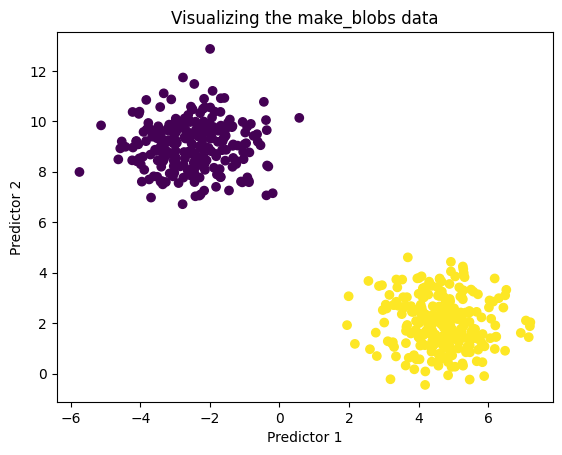

In [126]:
# Creating a scatterplot to visualize the relationship between the observations
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
plt.title('Visualizing the make_blobs data')
plt.show()

### Implementing a Linear Classifier in Gurobi